In [1]:
import poppy
import astropy.io.fits as fits
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import random

# Set up radial PSD distribution
def psd_model(k, psd_parm):
    # k: array/matrix of spatial frequencies
    # psd_parm: list with the PSD parameters
    alpha = psd_parm[0]
    beta = psd_parm[1]
    oscl = psd_parm[2]
    iscl = psd_parm[3]
    bsr = psd_parm[4]
    if oscl.value != 0:
        denom = ( ((1/oscl)**2) + (k**2))**(alpha/2)
    else: # explosion prevention
        denom = (k**2)**(alpha/2)
    pk = ((beta/denom) * np.exp(-((k.value*iscl)**2))) + bsr
    return pk

def get_rms(opd):
    return np.sqrt(np.mean(np.square(opd)))

def get_pv(opd):
    return np.amax(opd) - np.amin(opd)

### PowerSpectrumWFE Demonstration
Demonstrates background context for setting up PowerSpectrumWFE and how to use it

### PSD Model Reference information:
Males, J. 2017. MagAO-X Preliminary Design Review, Section 5.1 Optics Specifications
https://magao-x.org/docs/handbook/appendices/pdr/

Lumbres, J., et al. 2020. In Prep.

## Assumptions for using PowerSpectrumWFE
Requires a PSD modeled with the equation values listed in the reference. Can not build the wfe map from a surface map or the power spectrum radial profile.

### Setup 
First, assume there is a PSD with the following model parameters and radial distribution:

In [9]:
beta, bsr

(<Quantity 0.637 nm2 m(9/20)>, <Quantity 1.e-08 m2 nm2>)

Text(0.5, 1.0, 'Example PSD distribution')

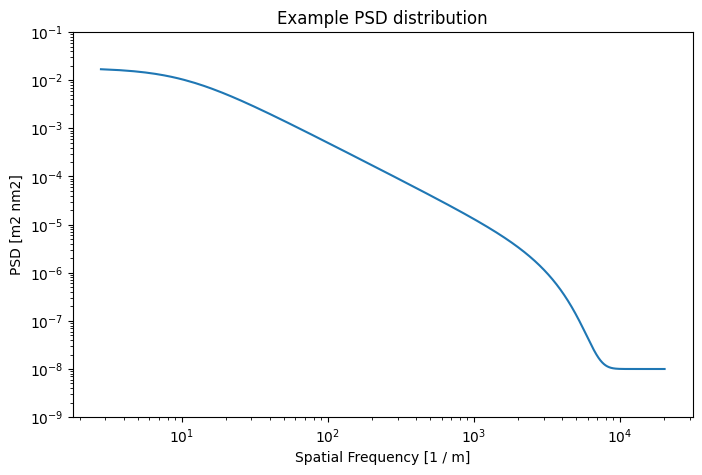

In [2]:
# Unit establishment - the model values provided here are determined by using these units
space_unit = u.m # POPPY defaults to meters, this is mandatory.
surface_unit = u.nm # Adjustable with modeling. PowerSpectrumWFE will produce opd in meters as POPPY requires.

# Test case parameters
alpha = 1.55
beta = 0.637 * (surface_unit**2) / (space_unit**(alpha-2))
oscl = (0.1*space_unit)
iscl = 0.0003
bsr = 1e-8 * (surface_unit*space_unit)**2 # original test case value is 0, adjusted for demo
parm_test = [[alpha, beta, oscl, iscl, bsr]]
weight_test = [1.0]

# Set up a spatial frequency range. Keep pretty fine spacing to see the lower spatial freq content.
k_range = (np.arange(start=2.8, stop=20176, step=0.95)/space_unit)
psd1 = psd_model(k_range, parm_test[0]) 
psd1 = psd1 * weight_test[0]

plt.figure(figsize=[8,5], dpi=100)
plt.loglog(k_range.value, psd1.value)
plt.ylim(top=0.1, bottom=1e-9)
plt.xlabel('Spatial Frequency [{0}]'.format(k_range.unit))
plt.ylabel('PSD [{0}]'.format(psd1.unit))
plt.title('Example PSD distribution')

### Comments about **PowerSpectrumWFE** arguments:
- **psd_parameters**: This is a list variable with astropy units attached. The parameters are determined prior after doing a model fit to PSD data. There can be multiple PSD parameter sets.
- **psd_weight**: A list with floats. There should be a weight value associated with each set in **psd_parameters**.
- **seed**: Random phase screen generation. Optional and defaults as ```None```. Caution: The default will be a brand new randomizer.
- **apply_reflection**: If the PSD parameters used did not have reflection wfe implemented during modeling and it is required for the opd, then choose True to apply 2x scale on the OPD. Defaults as ```False``` (assumes you don't want reflection).
- **screen_size**: Size of the 2D PSD in the spatial frequency plane. Should at least be bigger than the wavefront side. If the poppy Wavefront is already padded, then you can ignore this. Defaults as ```None```.
- **rms**: Set a wfe rms value to come out at randomized surface. Default at ```None```, which means use whatever RMS comes out from the random phase generator. However, if you pass in a value, you must also specify the ```radius```.
- **radius**: beam radius specified for scaling. Optional and only necessary if you pass in a value for ```rms```.
- **incident_angle**: Adjusts the opd based on the incident angle without elongating the beam (remains circular). Defaults as ```0*u.deg``` for a paraxial case.

### Example 1: wfe not applied

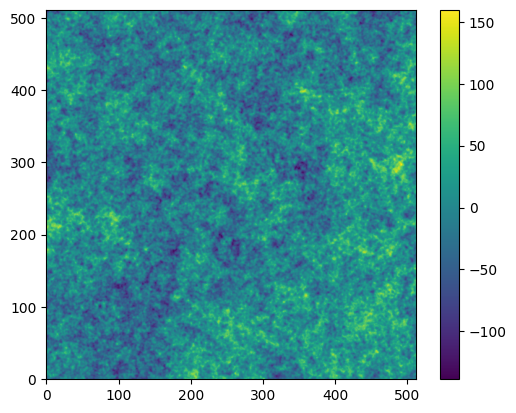

In [7]:
screen_size = 2048
seed = 123456
npix = 512
diam = 0.02587875072 * u.m
psd_wave = poppy.poppy_core.Wavefront(npix=npix, diam=diam, wavelength=656e-9)
psd_wfe = poppy.wfe.PowerSpectrumWFE(psd_parameters=parm_test, psd_weight=weight_test,
                                seed=seed, apply_reflection=True, screen_size=screen_size,
                                rms=None)
psd_opd = psd_wfe.get_opd(psd_wave)
# psd_opd = ((psd_wfe.get_opd(psd_wave))*u.m).to(surface_unit)
# psd_rms = get_rms(psd_opd)
# psd_pv = get_pv(psd_opd)

plt.figure(dpi=100)
plt.imshow(psd_opd.get()*1e9, origin='lower')
plt.colorbar()
# plt.imshow(psd_opd.value, origin='lower')
# plt.colorbar().set_label(psd_opd.unit)
# plt.title('PSD surf, RMS={0:.4f}, PV={1:.2f}'.format(psd_rms, psd_pv))

### Example 2: rms value applied
Applying a ```set_rms``` will rescale the surface map. The wfe rms will hold even with different random seeds and screen size in place, but note that the PV and the general randomized map will change.

Text(0.5, 1.0, 'PSD surf, RMS=16.8600 nm, PV=137.53 nm')

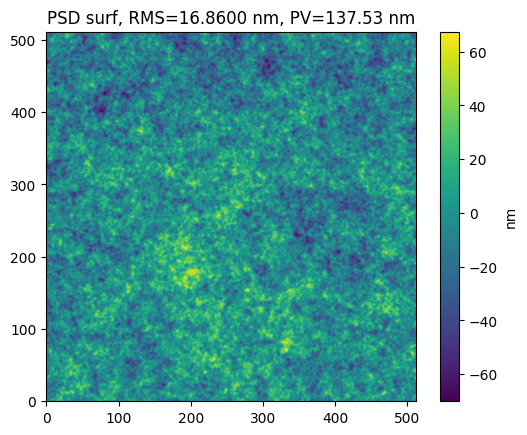

In [4]:
npix = 512
diam = 0.02587875072 * u.m

screen_size = 2048
seed = 123456
set_wfe = 8.43*u.nm
set_radius = npix*diam*0.5
psd_wave = poppy.poppy_core.Wavefront(npix=npix, diam=diam, wavelength=656e-9)
psd_wfe = poppy.wfe.PowerSpectrumWFE(psd_parameters=parm_test, psd_weight=weight_test,
                                seed=seed, apply_reflection=True, screen_size=screen_size,
                                rms=set_wfe, radius=set_radius)
psd_opd = ((psd_wfe.get_opd(psd_wave))*u.m).to(surface_unit)
psd_rms = get_rms(psd_opd)
psd_pv = get_pv(psd_opd)

plt.figure(dpi=100)
plt.imshow(psd_opd.value, origin='lower')
plt.colorbar().set_label(psd_opd.unit)
plt.title('PSD surf, RMS={0:.4f}, PV={1:.2f}'.format(psd_rms, psd_pv))

Text(0.5, 1.0, 'PSD surf, RMS=16.8600 nm, PV=138.52 nm')

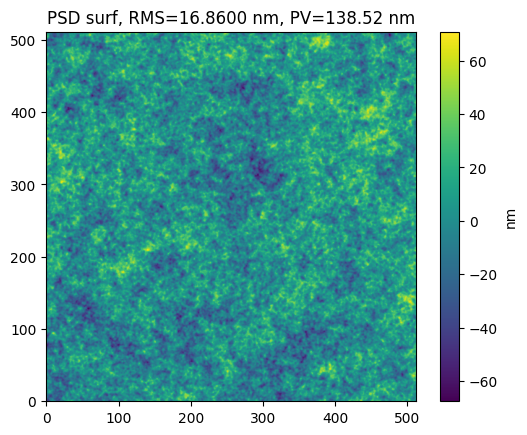

In [5]:
# Another example with a different seed value
npix = 512
diam = 0.02587875072 * u.m

screen_size = 1024
seed = 654321
set_rms = 8.43*u.nm
set_radius = npix*diam*0.5
psd_wave = poppy.poppy_core.Wavefront(npix=npix, diam=diam, wavelength=656e-9)
psd_wfe = poppy.wfe.PowerSpectrumWFE(psd_parameters=parm_test, psd_weight=weight_test,
                                seed=seed, apply_reflection=True, screen_size=screen_size,
                                rms=set_rms, radius=set_radius)
psd_opd = ((psd_wfe.get_opd(psd_wave))*u.m).to(surface_unit)
psd_rms = get_rms(psd_opd)
psd_pv = get_pv(psd_opd)

plt.figure(dpi=100)
plt.imshow(psd_opd.value, origin='lower')
plt.colorbar().set_label(psd_opd.unit)
plt.title('PSD surf, RMS={0:.4f}, PV={1:.2f}'.format(psd_rms, psd_pv))

Even though the optics had all the same PSD parameters, changing the seed value will adjust the randomized shape.